# BackTest EMA indicator

In [2]:
import pandas as pd
from datetime import timedelta


signals = pd.read_csv('EMA_4h_signal.csv', parse_dates=['timestamp'])[['timestamp','open', 'high', 'low','close', 'EMA','signal','EMA signal']]
df = pd.read_csv('ohlc_1m_data_last_day.csv', parse_dates=['timestamp'])


In [24]:
import time
from turtle import back
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

def ledger(signals, df, time_frame='4H'):
    """
    This function takes a dataframe of signals which is 4h interval data and df which is 1min interval data.
    """
    signals = signals
    df_1min = df
    action = []
    signal = []
    date_time = []
    buy_price = []
    sell_price = []
    pnl = []
    transaction_fee = 0.07 / 100
    profit_percentage = 0.05
    stop_loss_percentage = 0.02
    next_trade_time = None  
    def calculate_levels(buy, direction):
        if direction == 1:
            tp_price = buy + (buy * profit_percentage)
            sl_price = buy - (buy * stop_loss_percentage)
        elif direction == -1:
            tp_price = buy - (buy * profit_percentage)
            sl_price = buy + (buy * stop_loss_percentage)
        else:
            tp_price = sl_price = np.nan
        return tp_price, sl_price

    for i in range(len(signals)):
        if len(action) == 0 or (next_trade_time is not None and signals['timestamp'][i] >= next_trade_time):
            if signals['signal'][i] != 0:
                action.append(signals['signal'][i])
                date_time.append(signals['timestamp'][i])
                buy_price.append(signals['open'][i])
                buy = signals['open'][i]
                if signals['signal'][i] == 1:
                    signal.append('Buy')
                elif signals['signal'][i] == -1:
                    signal.append('Sell')
                sell_price.append(np.nan)
                pnl.append(np.nan)
                next_trade_time = None
                tp_price, sl_price = calculate_levels(buy, signals['signal'][i])
        else:
            if action[-1] == signals.iloc[i].signal or signals['signal'][i] == 0:
                if action[-1] == 1:
                    tp_price, sl_price = calculate_levels(buy, 1)
                elif action[-1] == -1:
                    tp_price, sl_price = calculate_levels(buy, -1)
                else:
                    continue 
                if i + 1 < len(signals):
                    next_signal_date = signals.loc[i + 1, 'timestamp']
                else:
                    next_signal_date = df_1min['timestamp'].max()
                end_datetime = signals.iloc[i]['timestamp']
                current_datetime = end_datetime - timedelta(hours=int(time_frame[0]))
                df_1min_slice = df_1min[(df_1min['timestamp'] >= current_datetime) & (df_1min['timestamp'] <= end_datetime)]
                df_1min_slice.reset_index(drop=True, inplace=True)

                for j in df_1min_slice.iterrows():
                    if j[1].high > tp_price and action[-1] == 1:
                        # Take profit
                        time = j[1].timestamp
                        sell_price.append(j[1].high)
                        action.append(action[-1])
                        signal.append('TP Hit')
                        date_time.append(time)
                        buy_price.append(np.nan)
                        pnl.append(np.nan)
                        next_trade_time = (pd.to_datetime(time) + pd.Timedelta(hours=(int(time_frame[0]) - pd.to_datetime(time).hour % 4))).replace(minute=0, second=0, microsecond=0)
                        break
                    elif j[1].low < sl_price and action[-1] == 1:
                        # Stop loss
                        time = j[1].timestamp
                        sell_price.append(j[1].low)
                        signal.append('SL Hit')
                        action.append(action[-1])
                        date_time.append(time)
                        buy_price.append(np.nan)
                        pnl.append(np.nan)
                        next_trade_time = (pd.to_datetime(time) + pd.Timedelta(hours=(int(time_frame[0]) - pd.to_datetime(time).hour % 4))).replace(minute=0, second=0, microsecond=0)
                        break
                    elif j[1].low < tp_price and action[-1] == -1:
                        # Take profit
                        time = j[1].timestamp
                        sell_price.append(j[1].low)
                        action.append(action[-1])
                        signal.append('TP Hit')
                        date_time.append(time)
                        buy_price.append(np.nan)
                        pnl.append(np.nan)
                        next_trade_time = (pd.to_datetime(time) + pd.Timedelta(hours=(int(time_frame[0]) - pd.to_datetime(time).hour % 4))).replace(minute=0, second=0, microsecond=0)
                        break
                    elif j[1].high > sl_price and action[-1] == -1:
                        # Stop loss
                        time = j[1].timestamp
                        sell_price.append(j[1].high)
                        action.append(action[-1])
                        signal.append('SL Hit')
                        date_time.append(time)
                        buy_price.append(np.nan)
                        pnl.append(np.nan)
                        next_trade_time = (pd.to_datetime(time) + pd.Timedelta(hours=(int(time_frame[0]) - pd.to_datetime(time).hour % 4))).replace(minute=0, second=0, microsecond=0)
                        break
            else:
                if action[-1] in ['tp hit', 'sl hit']:
                    if signals['signal'][i] == 0:
                        continue  # Ignore if the new signal is 0
                    action.append(signals['signal'][i])
                    date_time.append(signals['timestamp'][i])
                    buy_price.append(signals['open'][i])
                    signal.append('Buy')
                    buy = signals['open'][i]
                    sell_price.append(np.nan)
                    pnl.append(np.nan)
                    next_trade_time = None
                else:
                    action.append(signals['signal'][i])
                    date_time.append(signals['timestamp'][i])
                    sell_price.append(signals['open'][i])
                    buy = signals['open'][i]
                    if signals['signal'][i] == 1:
                        signal.append('Buy')
                    elif signals['signal'][i] == -1:
                        signal.append('Sell')
                    buy_price.append(np.nan)
                    pnl.append(np.nan)

                    action.append(signals['signal'][i])
                    date_time.append(signals['timestamp'][i])
                    buy_price.append(signals['open'][i])
                    buy = signals['open'][i]
                    if signals['signal'][i] == 1:
                        signal.append('Buy')
                    elif signals['signal'][i] == -1:
                        signal.append('Sell')
                    sell_price.append(np.nan)
                    pnl.append(np.nan)
                    
    ledger_df = pd.DataFrame({
        'date_time': date_time, 
        'signal': signal, 
        'action': action, 
        'buy_price': buy_price, 
        'sell_price': sell_price, 
        'pnl': pnl
    })
    ledger_df['action'] = ledger_df['action'].replace({1: 'Buy', -1: 'Sell', 0: 'Hold'})
    ledger_df['buy_price'] = ledger_df['buy_price'].fillna(method='ffill')
    ledger_df['signal'] = ledger_df['signal'].replace({1: 'Buy', -1: 'Sell', 0: 'Hold'})
    ledger_df['action'] = ledger_df['action'].replace({'Buy': 'Long', 'Sell': 'Short'})
    def calculate_pnl_and_balance(df):
        balance = 10000  
        balances = []  
        for index, row in df.iterrows():
            buy_price = float(row['buy_price'])
            sell_price = float(row['sell_price'])
            if pd.isna(sell_price) or pd.isna(buy_price):
                balances.append(balance)  
                continue
            if df.iloc[index-1]['signal'] == 'Buy':  # Long
                pnl_percent = ((sell_price - buy_price) / buy_price) * 100
            elif df.iloc[index-1]['signal'] == 'Sell':  # Short
                pnl_percent = ((buy_price - sell_price) / buy_price) * 100
            else:
                pnl_percent = 0
            pnl_change = balance * (pnl_percent / 100)  
            balance += pnl_change  
            balances.append(balance)  
            df.at[index, 'pnl'] = round(pnl_percent, 2)  
        df['balance'] = balances  
        return df
    ledger_with_pnl = calculate_pnl_and_balance(ledger_df.copy())  
    return ledger_with_pnl
result = ledger(temp, temp2, '4H')
print(result)


              date_time  signal action  buy_price  sell_price    pnl  \
0   2024-05-01 04:00:00    Sell  Short   60246.02         NaN    NaN   
1   2024-05-01 08:00:00     Buy   Long   60246.02    57500.00   4.56   
2   2024-05-01 08:00:00     Buy   Long   57500.00         NaN    NaN   
3   2024-05-01 12:00:00    Sell  Short   57500.00    57898.46   0.69   
4   2024-05-01 12:00:00    Sell  Short   57898.46         NaN    NaN   
..                  ...     ...    ...        ...         ...    ...   
587 2024-08-11 04:00:00  TP Hit   Long   61085.01   100000.00  63.71   
588 2024-08-11 12:00:00    Sell  Short   60660.00         NaN    NaN   
589 2024-08-11 12:06:00  TP Hit  Short   60660.00    50000.01  17.57   
590 2024-08-11 20:00:00    Sell  Short   59662.01         NaN    NaN   
591 2024-08-11 20:05:00  TP Hit  Short   59662.01    52553.00  11.92   

          balance  
0    1.000000e+04  
1    1.045580e+04  
2    1.045580e+04  
3    1.052826e+04  
4    1.052826e+04  
..            .

C:\Users\MTariq\AppData\Local\Temp\ipykernel_11216\3243426834.py:161: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ledger_df['buy_price'] = ledger_df['buy_price'].fillna(method='ffill')


In [11]:
 temp = signals [9493:].copy().reset_index(drop = True)
 temp

,timestamp,open,high,low,close,EMA,signal,EMA signal
0,2024-05-01 04:00:00,60246.02,60361.09,57100.00,57499.99,57640.900612,-1,Sell
1,2024-05-01 08:00:00,57500.00,57909.00,56552.82,57898.47,57763.570427,1,Buy
2,2024-05-01 12:00:00,57898.46,58275.87,56674.51,56886.00,56907.950831,-1,Sell
3,2024-05-01 16:00:00,56886.00,59468.00,56625.09,56954.47,57289.225689,-1,Sell
4,2024-05-01 20:00:00,56954.46,58575.32,56760.02,58364.97,58327.227534,1,Buy
...,...,...,...,...,...,...,...,...
613,2024-08-11 08:00:00,61257.01,200000.00,40000.00,60659.96,60611.683603,1,Buy
614,2024-08-11 12:00:00,60660.00,200200.00,33000.00,60040.01,60205.612345,-1,Sell
615,2024-08-11 16:00:00,60040.04,74902.61,21683.75,59662.02,59708.568672,-1,Sell
616,2024-08-11 20:00:00,59662.01,61697.00,36133.00,58711.99,58798.934860,-1,Sell


In [23]:

temp2 = df[2278080:].copy().reset_index(drop=True)
temp2

,timestamp,open,high,low,close,volume
0,2024-05-01 00:00:00,60672.01,60750.00,60660.98,60742.33,55.30759
1,2024-05-01 00:01:00,60742.33,60779.52,60721.76,60757.86,15.62630
2,2024-05-01 00:02:00,60757.87,60757.87,60675.20,60678.13,38.57373
3,2024-05-01 00:03:00,60678.13,60709.96,60675.21,60709.96,9.00795
4,2024-05-01 00:04:00,60709.96,60728.00,60688.39,60688.39,27.67657
...,...,...,...,...,...,...
148316,2024-08-11 23:56:00,58793.21,58794.13,50000.00,58761.28,1.27200
148317,2024-08-11 23:57:00,58749.75,58843.46,50000.00,58717.27,0.36614
148318,2024-08-11 23:58:00,58717.27,58717.27,58700.39,58713.73,0.13860
148319,2024-08-11 23:59:00,58715.99,58718.00,58680.11,58711.99,0.21365


In [25]:
result.head(40)

,date_time,signal,action,buy_price,sell_price,pnl,balance
0,2024-05-01 04:00:00,Sell,Short,60246.02,NaN,NaN,10000.000000
1,2024-05-01 08:00:00,Buy,Long,60246.02,57500.00,4.56,10455.801064
2,2024-05-01 08:00:00,Buy,Long,57500.00,NaN,NaN,10455.801064
3,2024-05-01 12:00:00,Sell,Short,57500.00,57898.46,0.69,10528.257037
4,2024-05-01 12:00:00,Sell,Short,57898.46,NaN,NaN,10528.257037
5,2024-05-01 20:00:00,Buy,Long,57898.46,56954.46,1.63,10699.914015
6,2024-05-01 20:00:00,Buy,Long,56954.46,NaN,NaN,10699.914015
7,2024-05-02 00:00:00,Sell,Short,56954.46,58364.97,2.48,10964.903547
8,2024-05-02 00:00:00,Sell,Short,58364.97,NaN,NaN,10964.903547
9,2024-05-02 08:00:00,Buy,Long,58364.97,57681.08,1.17,11093.384516


C:\Users\MTariq\AppData\Local\Temp\ipykernel_11216\3243426834.py:161: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ledger_df['buy_price'] = ledger_df['buy_price'].fillna(method='ffill')


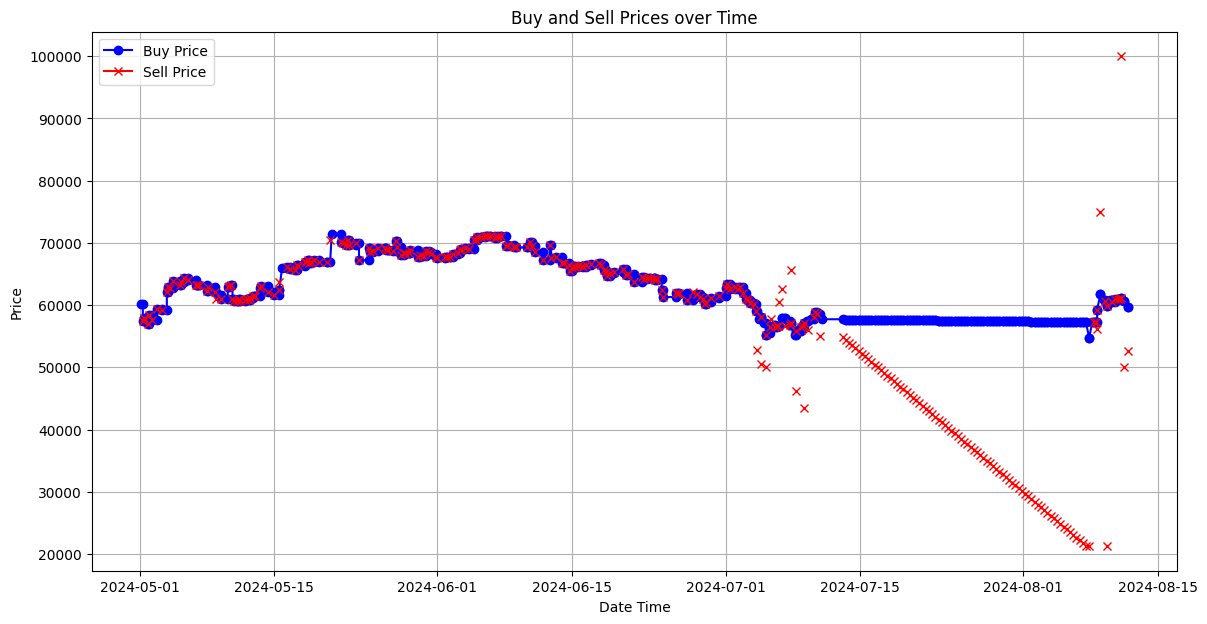

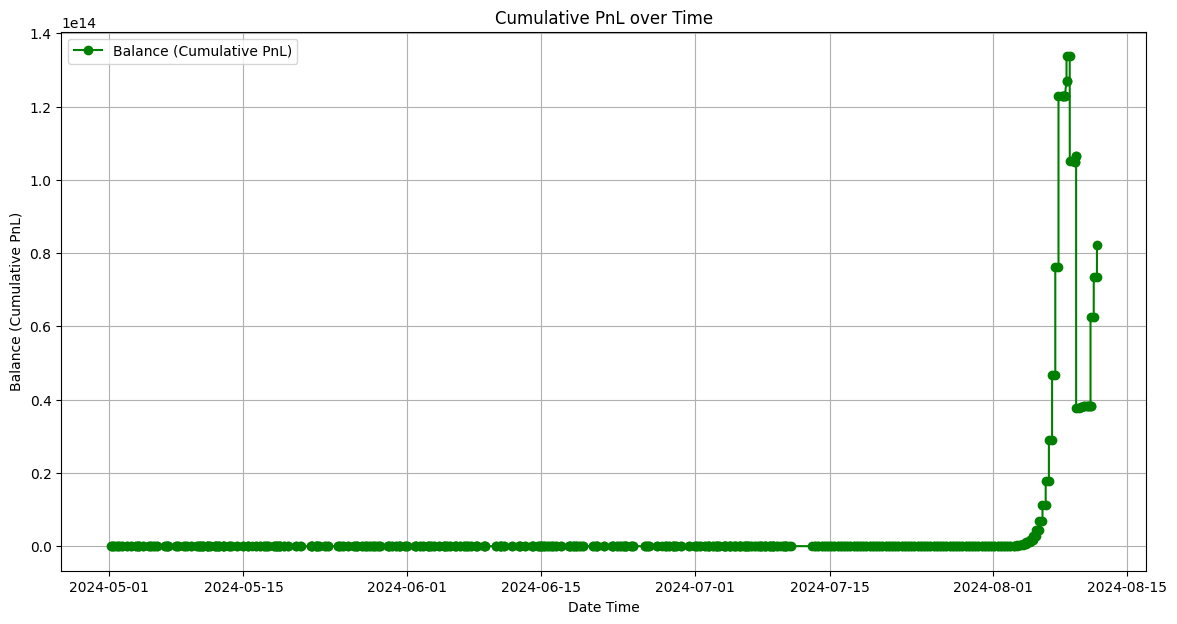

In [26]:
import matplotlib.pyplot as plt

def visualize_ledger(ledger_df):
    result['date_time'] = pd.to_datetime(result['date_time'])
    plt.figure(figsize=(14, 7))
    plt.plot(result['date_time'], result['buy_price'], label='Buy Price', marker='o', linestyle='-', color='blue')
    plt.plot(result['date_time'], result['sell_price'], label='Sell Price', marker='x', linestyle='-', color='red') 
    plt.xlabel('Date Time')
    plt.ylabel('Price')
    plt.title('Buy and Sell Prices over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(14, 7))
    plt.plot(result['date_time'], result['balance'], label='Balance (Cumulative PnL)', marker='o', linestyle='-', color='green')
    plt.xlabel('Date Time')
    plt.ylabel('Balance (Cumulative PnL)')
    plt.title('Cumulative PnL over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
result = ledger(temp, temp2)
visualize_ledger(result)
